# Predicting Planting Intentions

## Background
Every year the USDA releases the results of a survey of planting intentions for farmers in the US. Responses are collected the first two weeks of March and released as an aggregate planting value for each state and crop combination. 

This notebook is an attempt to make a rough prediction of what this number may be, given data sources only up to the 29th of March (the day this data is released). 

It is important to note this prediction is done using a combination of previous years' data and current pricing information, and as such will *always* be less accurate than a representative sample of the exact intentions of farmers (as the USDA completes). However, it may give a useful indication of the trend or direction of change. 

## Methodology
There is a multitude of crop-state combinations released in the [USDA ERS](https://app.gro-intelligence.com/dictionary/sources/63) prospective plantings report. For the purposes of this prototype model we are focusing on predicting only the corn planted area (in ha), and only in the [corn belt](https://app.gro-intelligence.com/dictionary/regions/100000100). This limitation makes the data collection process feasible and allows us to optimize the model on this subset of the information. 

Optimization and testing for each crop-state combination would be a given for any crop model used in production in, for instance, a real-world trading scenario, but this would be labourious task.  

In [1]:
import os
import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats

In [14]:
# make the magic happen - import the Gro library
from api.client import Client
api_host = "api.gro-intelligence.com"
client = Client(api_host, os.environ["GROAPI_TOKEN"])

# get counties for north dak
# get the years we have data available:
start_year = 1995
end_year = 2020

num_samples = end_year - start_year

In [4]:
# pull the corn belt states from Gro
state_ids = {
    client.lookup("regions", state_id)["name"]: state_id 
    for 
    state_id 
    in client.lookup('regions', 100000100)["contains"] 
    if client.lookup("regions", state_id)["name"] not in ["District of Columbia", "Hawaii", "Alaska"]
}

# resreg = resource region as defined by ers
county_to_resreg = {}
state_to_counties = {}
state_training_data = {}

# get county level data
for state_id in state_ids.values():
    
    state_obj = client.lookup("regions", state_id)
    
    # the contains field will contain all the next level region data - i.e. counties in this case (aka districts)
    state_to_counties[state_id] = []
    
    # find first county that has an ers region
    for county in state_obj["contains"]:
        
        county_obj = client.lookup("regions", county)
        
        # counties are always level 5
        if county_obj["level"] != 5:
            continue
        
        state_to_counties[state_id].append(county)
        
        for parent_region_obj in client.lookup_belongs("regions", county):
            # resource regions happen to be in this interval of ids
            if parent_region_obj["id"] in range(100000140, 100000149):
                county_to_resreg[county] = parent_region_obj ["id"]
            
        if county not in county_to_resreg:
            print("couldn't find a resreg for county with id %s and name %s in state %s, deleting" % (county, county_information["name"], result["name"]))
            del state_to_counties[state_id][state_to_counties[state_id].index(county)]
            

## Features

As with any statistical model, we have to collect a number of features of predictor data. Based on domain expertise, we have selected a number of data features available in Gro. The features are grouped by the region granularity that they are available at (country, state, county, and "Ag Districts", which ERS-defined regions grouping counties within states -- e.g. [Alabama Ag District 40](https://app.gro-intelligence.com/dictionary/regions/100000197)), as well as their requisite item, metric pairs for access via Gro. 

In [5]:
#Define and collect all the data series we may be interested in. This is collected from the Viz. 
crop_ids = {
    "corn": 274,
    "soybeans": 270,
    "wheat": 95,
    "hard_red_wheat": 2484, #for futures
    "corn_fsa": 10446,
    "soybeans_fsa": 10509,  
    "cotton_fsa": 10447,
    "wheat_fsa": 10521,
    "cotton": 7077,
    "upland_cotton": 3253 # this is upland cotton but pima cotton seems uninteresting.
}

non_fsa_crops = ('corn', 'soybeans', 'wheat', 'upland_cotton')
ers_crops = ('corn', 'soybeans', 'wheat', 'cotton')
fsa_crops = ('corn_fsa', 'soybeans_fsa', 'cotton_fsa', 'wheat_fsa')
futures_crops = ('corn', 'soybeans', 'hard_red_wheat', 'cotton')

mapping_to_non_fsa = {
    'corn_fsa': 'corn',
    'corn': 'corn',
    'soybeans_fsa': 'soybeans',
    'wheat_fsa': 'wheat', 
    'upland_cotton': 'upland_cotton',
    'wheat': 'wheat',
    'hard_red_wheat': 'wheat',
    'cotton_fsa': 'upland_cotton',
    'cotton': 'upland_cotton',
    'soybeans': 'soybeans',
}

features = {
    "country": {
        "futures_price_dec_march": { # for corn we miss this for 1995-1997 so just impute it from fixed values..
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'crops': futures_crops,
            'sample_date': (12, 31),
            'report_date': (3, 28),
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 15820065, #settle price
            'source_id': 81, 
            'frequency_id': 15, 
            'show_revisions': True
        },
        "futures_price_dec_june": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'crops': futures_crops,
            'sample_date': (12, 31),
            'report_date': (6, 30),
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 15820065, #settle price
            'source_id': 81, 
            'frequency_id': 15, 
            'show_revisions': True
        },
        "futures_price_dec_nov": {
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'crops': futures_crops,
            'sample_date': (12, 31),
            'report_date': (11, 10), #bit earlier as some futures don't have december only nov 30 expiration.
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 15820065,  #settle price
            'source_id': 81, 
            'frequency_id': 15, 
            'show_revisions': True
        },
        "producer_prices_country_yearly": { # no need to impute - fully downloaded
            'impute': 'impute',
            'crops': non_fsa_crops,
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "producer_prices_country_march": {
            'crops': non_fsa_crops,
            'impute': "producer_prices_yearly", # impute with yearly values if something's missing.
            'impute_type': "same",
            'sample_date': (3, 31),
            'feature_type': 'relative',
            'level': 3,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 6
        }
    },
    "ers_region": {
        "operating_costs_ers": {
            'impute': 'impute',
            'crops': ers_crops,
            'feature_type': 'relative',
            'level': 8,
            'metric_id': 15850182, 
            'source_id': 63, 
            'frequency_id': 9
        },
        "overhead_costs_ers": {
            'impute': 'impute',
            'crops': ers_crops,
            'feature_type': 'relative',
            'level': 8,
            'metric_id': 15850183,
            'source_id': 63, 
            'frequency_id': 9
        },
        "land_opportunity_cost_ers": {
            'impute': 'impute',
            'crops': ers_crops,
            'feature_type': 'relative',
            'level': 8,
            'metric_id': 8591080, 
            'source_id': 63, 
            'frequency_id': 9
        }
    },
    "state": {
        "area_planted_state_march": {
            'crops': non_fsa_crops,
            'feature_type': 'relative', # this is relative to county levels. 
            'impute': "area_planted_nass_final_state", # use the state value.
            'impute_type': "same",
            'report_date': (3, 31),
            'level': 4,
            'metric_id': 2580001, 
            'source_id': 25, 
            'frequency_id': 9,
            'show_revisions': True
        },
        "producer_prices_yearly": { # no need to impute - fully downloaded
            'impute': "producer_prices_country_yearly", # impute with yearly values if something's missing.
            'impute_type': 'same',
            'crops': non_fsa_crops,
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "producer_prices_march": {
            'crops': non_fsa_crops,
            'impute': "producer_prices_country_march", # impute with yearly values if something's missing.
            'impute_type': "same",
            'sample_date': (3, 31),
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2290065, 
            'source_id': 25, 
            'frequency_id': 6
        },
        "area_planted_nass_final_state": { #nothings missing currently so don't impute
            'crops': non_fsa_crops,
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 2580001, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "area_harvested_nass_state": { #nothings missing currently so don't impute
            'crops': non_fsa_crops,
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 570001, 
            'source_id': 25, 
            'frequency_id': 9,
        }, 
        "production_nass_state": { #nothings missing currently so don't impute
            'crops': non_fsa_crops,
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 860032, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "yield_nass_state": { #nothings missing currently so don't impute
            'crops': non_fsa_crops,
            'feature_type': 'relative',
            'level': 4,
            'metric_id': 170037, 
            'source_id': 25, 
            'frequency_id': 9
        }
    },
    "county":{
        "fsa_area_failed_irrigated": {
            'crops': fsa_crops,
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850168, 
            'source_id': 100, 
            'frequency_id': 9,
            'show_revisions': True
        },
        "fsa_area_failed_non_irrigated": {
            'crops': fsa_crops,
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 15850173,
            'source_id': 100, 
            'frequency_id': 9, 
            'show_revisions': True
        },
        "fsa_area_planted_irrigated": {
            'crops': fsa_crops,
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3280001, 
            'source_id': 100, 
            'frequency_id': 9,
            'show_revisions': True
        },
        "fsa_area_planted_non_irrigated": {
            'crops': fsa_crops,
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'feature_type': 'absolute',
            'level': 5,
            'metric_id': 3300001,
            'source_id': 100, 
            'frequency_id': 9, 
            'show_revisions': True
        },
        "area_planted_nass_final": {
            'crops': non_fsa_crops,
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 2580001, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "area_harvested_nass": {
            'crops': non_fsa_crops,
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 570001, 
            'source_id': 25, 
            'frequency_id': 9,
        }, 
        "production_nass": {
            'crops': non_fsa_crops,
            'feature_type': 'absolute',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 860032, 
            'source_id': 25, 
            'frequency_id': 9
        },
        "yield_nass": {
            'crops': non_fsa_crops,
            'feature_type': 'relative',
            'impute': "area_planted_nass_final_state",
            'impute_type': "relative",
            'level': 5,
            'metric_id': 170037, 
            'source_id': 25, 
            'frequency_id': 9
        }
    }
}

def get_features_list(features):
    features_list = []
    for region_type in ["country", "ers_region", "state", "county"]:
        region_series = features[region_type]
        for series_name, series in region_series.items():
            for crop_name in series['crops']:
                features_list.append("%s_%s" % (series_name, crop_name))
    return features_list

features_list = get_features_list(features)
num_features = len(features_list)
print("proceeding to download {} features".format(num_features))

['futures_price_dec_june_corn', 'futures_price_dec_june_soybeans', 'futures_price_dec_june_hard_red_wheat', 'futures_price_dec_june_cotton', 'futures_price_dec_nov_corn', 'futures_price_dec_nov_soybeans', 'futures_price_dec_nov_hard_red_wheat', 'futures_price_dec_nov_cotton', 'futures_price_dec_march_corn', 'futures_price_dec_march_soybeans', 'futures_price_dec_march_hard_red_wheat', 'futures_price_dec_march_cotton', 'producer_prices_country_march_corn', 'producer_prices_country_march_soybeans', 'producer_prices_country_march_wheat', 'producer_prices_country_march_upland_cotton', 'producer_prices_country_yearly_corn', 'producer_prices_country_yearly_soybeans', 'producer_prices_country_yearly_wheat', 'producer_prices_country_yearly_upland_cotton', 'overhead_costs_ers_corn', 'overhead_costs_ers_soybeans', 'overhead_costs_ers_wheat', 'overhead_costs_ers_cotton', 'land_opportunity_cost_ers_corn', 'land_opportunity_cost_ers_soybeans', 'land_opportunity_cost_ers_wheat', 'land_opportunity_cos

In [7]:
# OTHER STUFF
other_data_series = {
    #yearly, country level
    "interest_rate_us": {
        'level': 3,
        'metric_id': 5020042, 
        'item_id': 4512, 
        'region_id': 1215, 
        'source_id': 25, 
        'frequency_id': 9
    },
    "cpi_us": {
        'metric_id': 950029, 
        'item_id': 4504, 
        'region_id': 1215, 
        'source_id': 6, 
        'frequency_id': 9
    }
}


# yearly, country level.
#CPI = client.get_data_points(**)
#CPI = {int(point["end_date"][0:4]) : float(point["value"]) for point in CPI}

## Data download from Gro

Gro data is provided in a "raw" form - that is, we do minimal post-processing in order to allow the end-user the most flexibility in handling the data. This means we do not impute values in the API on our end and we try to provide it in a way as close as possible to the ground truth data from the source. 

The data points themselves are provided as simple point-value pairs or triplets. The most basic case of a time-series is simply points associated with a given timestamp. However, in some cases a point is revised or re-released from a source - in this case each point is associated with two time-staps - a "reporting date and an "end date".

In [150]:
for state_id in state_ids.values():
    
    num_counties = len(state_to_counties[state_id])
    training_data = np.ma.zeros((num_counties, num_samples, num_features))
    state_training_data[state_id] = training_data
    
    feature_idx = 0
    
    # Get all the crop-specific data series info
    for region_type in ["country", "ers_region", "state", "county"]:
        for series_name, query in features[region_type].items():
            for crop_name in query["crops"]:
                crop_id = crop_ids[crop_name]
                for county_idx, county_id in enumerate(state_to_counties[state_id]):
                    probable_series = None

                    query["item_id"] = crop_id

                    if query['level'] == 8:
                        query["region_id"] = county_to_resreg[county_id]
                    elif query['level'] == 5:
                        query['region_id'] = county_id
                    elif query['level'] == 4:
                        query['region_id'] = state_id
                    elif query['level'] == 3:
                        query['region_id'] = 1215

                    result = client.get_data_series(**query)
                    useful_series = []

                    for possible_series in result: 
                        series_start_year = int(possible_series["start_date"][0:4])
                        series_end_year = int(possible_series["end_date"][0:4])
                        if ((series_start_year <= start_year < series_end_year) 
                                                   or (series_start_year < end_year <= series_end_year)
                                                   or (start_year <= series_start_year and series_end_year <= end_year)):
                            useful_series.append(possible_series)

                    for series in useful_series:

                        if "show_revisions" in query and query["show_revisions"]:
                            series["show_revisions"] = True

                        # Let's actually download the data
                        data_points = client.get_data_points(**series)
                        number_sample_points = 0

                        cache = np.ma.zeros(num_samples)
                        cache[:] = np.ma.masked

                        for point in data_points:
                            #if we have a sample date, let's pick the point that's closest to this point
                            last_sampled_date = None
                            last_reported_date = None
                            sample_deadline = datetime.datetime(int(point["end_date"][0:4]), query["sample_date"][0], query["sample_date"][1]) if "sample_date" in query else None 
                            report_deadline = datetime.datetime(int(point["end_date"][0:4]), query["report_date"][0], query["report_date"][1]) if "report_date" in query else None 
                            if "reporting_date" in point and point["reporting_date"] is not None:
                                reported_date = datetime.datetime.strptime(point["reporting_date"], '%Y-%m-%dT%H:%M:%S.%fZ')
                            else:
                                reported_date = None
                            end_date = datetime.datetime.strptime(point["end_date"], '%Y-%m-%dT%H:%M:%S.%fZ')

                            sample_idx = int(point["end_date"][0:4]) - start_year

                            if 0 <= sample_idx < num_samples:

                                if sample_deadline is not None and end_date > sample_deadline :
                                    #continue to next point as this is after the date we want to grab it.
    #                                 print("past sample deadline")
    #                                 print(end_date)
                                    continue
                                if last_sampled_date is not None and end_date < last_sampled_date:
    #                                 print("newer sample date avail, ignoring this")
                                    continue
                                if report_deadline is not None and reported_date is not None and reported_date > report_deadline:
    #                                 print("past report deadline")
    #                                 print(reported_date)
                                    continue
                                if last_reported_date is not None and reported_date < last_reported_date:
    #                                 print("newer report date avail")
                                    continue
                                
                                #unmask potentially
                                if cache[sample_idx] == np.ma.masked:
                                    cache[sample_idx] = 0.0
                            
                                if (last_sampled_date is not None and end_date == last_sampled_date) and (last_reported_date is None or reported_date == last_reported_date):
                                    cache[sample_idx] +=  point["value"]
                                else:
                                    cache[sample_idx] = point["value"]
                                    last_sampled_date = end_date
                                    last_reported_date = reported_date

                                number_sample_points += 1
                    
                        # masked + nonmasked => masked
                        training_data[county_idx, :, feature_idx] += cache

                        #if the data we're getting is not county level - use this for all other counties and go to next feature
                        print("Downloaded %s in %s for %s, county_idx=%i, num_samples=%i, feature=%i" % (series_name, state_id, crop_name, county_idx, number_sample_points, feature_idx))
                    if query["level"] == 4 or query["level"] == 3:
                        print("copying state or country data to other counties so we don't have to download")
                        training_data[:, :, feature_idx] = training_data[county_idx, :, feature_idx]
                        break

                # IMPORTANT INDENDATION LEVEL, next feature...
                feature_idx += 1


Downloaded futures_price_dec_june in 13092 for corn, county_idx=0, num_samples=67996, feature=0
copying state or country data to other counties so we don't have to download
Downloaded futures_price_dec_june in 13092 for soybeans, county_idx=0, num_samples=77015, feature=1
copying state or country data to other counties so we don't have to download
Downloaded futures_price_dec_june in 13092 for hard_red_wheat, county_idx=0, num_samples=12260, feature=2
copying state or country data to other counties so we don't have to download
Downloaded futures_price_dec_june in 13092 for cotton, county_idx=0, num_samples=6622, feature=3
copying state or country data to other counties so we don't have to download
Downloaded futures_price_dec_nov in 13092 for corn, county_idx=0, num_samples=72036, feature=4
copying state or country data to other counties so we don't have to download
Downloaded futures_price_dec_nov in 13092 for soybeans, county_idx=0, num_samples=81652, feature=5
copying state or count

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Downloaded operating_costs_ers in 13076 for corn, county_idx=30, num_samples=22, feature=28
Downloaded operating_costs_ers in 13076 for corn, county_idx=31, num_samples=22, feature=28
Downloaded operating_costs_ers in 13076 for corn, county_idx=32, num_samples=22, feature=28
Downloaded operating_costs_ers in 13076 for corn, county_idx=33, num_samples=22, feature=28
Downloaded operating_costs_ers in 13076 for corn, county_idx=34, num_samples=22, feature=28
Downloaded operating_costs_ers in 13076 for corn, county_idx=35, num_samples=22, feature=28
Downloaded operating_costs_ers in 13076 for corn, county_idx=36, num_samples=22, feature=28
Downloaded operating_costs_ers in 13076 for corn, county_idx=37, num_samples=22, feature=28
Downloaded operating_costs_ers in 13076 for corn, county_idx=38, num_samples=22, feature=28
Downloaded operating_costs_ers in 13076 for corn, county_idx=39, num_samples=22, feature=28
Downloaded operating_costs_ers in 13076 for corn, county_idx=40, num_samples=22,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Downloaded fsa_area_planted_non_irrigated in 13100 for wheat_fsa, county_idx=10, num_samples=20, feature=71
Downloaded fsa_area_planted_non_irrigated in 13100 for wheat_fsa, county_idx=10, num_samples=5, feature=71
Downloaded fsa_area_planted_non_irrigated in 13100 for wheat_fsa, county_idx=10, num_samples=10, feature=71
Downloaded fsa_area_planted_non_irrigated in 13100 for wheat_fsa, county_idx=10, num_samples=5, feature=71
Downloaded fsa_area_planted_non_irrigated in 13100 for wheat_fsa, county_idx=10, num_samples=5, feature=71
Downloaded fsa_area_planted_non_irrigated in 13100 for wheat_fsa, county_idx=11, num_samples=16, feature=71
Downloaded fsa_area_planted_non_irrigated in 13100 for wheat_fsa, county_idx=11, num_samples=8, feature=71
Downloaded fsa_area_planted_non_irrigated in 13100 for wheat_fsa, county_idx=11, num_samples=39, feature=71
Downloaded fsa_area_planted_non_irrigated in 13100 for wheat_fsa, county_idx=11, num_samples=11, feature=71
Downloaded fsa_area_planted_non_

In [15]:
import pickle
#pickle.dump(state_training_data, open("state_data.pickle", "wb"))
state_training_data = pickle.load(open("state_data.pickle", "rb"))

In [16]:
###### For cotton futures we import these values.
import pandas as pd
cotton_futures = pd.read_excel('cotton.xlsx', index_col=0)
for year_offset in range(0, num_samples):
    year = 1995+year_offset
    futures_avail = ["futures_price_dec_march",
                     "futures_price_dec_june",
                     "futures_price_dec_nov"]
    for future_feature in futures_avail:
        future_feature_idx = features_list.index(future_feature + "_cotton")
        date_tup = ((year,) + features["country"][future_feature]["report_date"])
        date = datetime.date(*date_tup)
        for entry in cotton_futures.iterrows():
            # list is decreasing so grab the first good point
            if pd.to_datetime(entry[0]).date() < date and entry[1]["Close"] != "---":
                print(pd.to_datetime(entry[0]).date())
                print(future_feature)
                val = 22.0462262 * entry[1]["Close"] #conversion of bushel
                print("new", val)
                for name, state_id in state_ids.items():
                    training_data = state_training_data[state_id]
                    training_data[:, year_offset, future_feature_idx] = val
                break

1999-03-26
futures_price_dec_march
('new', 1353.63828868)
1999-06-29
futures_price_dec_june
('new', 1272.06725174)
1999-11-09
futures_price_dec_nov
('new', 1250.02102554)
2000-03-27
futures_price_dec_march
('new', 1351.43366606)
2000-06-29
futures_price_dec_june
('new', 1282.428978054)
2000-11-09
futures_price_dec_nov
('new', 1432.1228539519998)
2001-03-27
futures_price_dec_march
('new', 1115.53904572)
2001-06-29
futures_price_dec_june
('new', 943.798943622)
2001-11-09
futures_price_dec_nov
('new', 722.675294836)
2002-03-27
futures_price_dec_march
('new', 970.4748773240001)
2002-06-28
futures_price_dec_june
('new', 1091.949583686)
2002-11-08
futures_price_dec_nov
('new', 1066.816885818)
2003-03-27
futures_price_dec_march
('new', 1285.515449722)
2003-06-27
futures_price_dec_june
('new', 1296.979487346)
2003-11-07
futures_price_dec_nov
('new', 1703.511898474)
2004-03-26
futures_price_dec_march
('new', 1511.7097305339998)
2004-06-29
futures_price_dec_june
('new', 1166.4658282419998)
2004-

In [75]:
### Custom imputation of things with missing values.

# First, all the relative ones that are crop-related we make the big assumption
# that each correlates with the yearly production of that crop in that district...

imputed_state_training_data = {}

for name, state_id in state_ids.items():
    training_data = state_training_data[state_id]

    training_data = training_data.copy()
    imputed_state_training_data[state_id] = training_data
    feature_idx = -1
    
    # Get all the crop-specific data series info
    for region_type in ["country", "ers_region", "state", "county"]:
        region_series = features[region_type]
        for series_name, series in region_series.items():
            for crop_name in series['crops']:
                feature_idx += 1
                if "impute" not in series:
                    if np.ma.is_masked(training_data[:, :, feature_idx]):
                        continue
                        #print("FAIL with series " + features_list[feature_idx] + " in state " + name) #assert(not np.ma.is_masked(training_data[:, :, feature_idx])) #check we can fill in all DATA
                        #print(training_data[0, :, feature_idx])
                elif "impute" in series:
                    if series["impute"] != "impute":
                        reference_name = series["impute"] + "_" + mapping_to_non_fsa[crop_name]
                        if reference_name not in features_list:
                            reference_name = series["impute"] + "_" + crop_name
                        reference_idx = features_list.index(reference_name)
                    if "impute_type" in series and series["impute_type"] == "same":
                        print("doing copying of values for  {}".format(features_list[feature_idx]))
                        training_data[:, :, feature_idx][training_data.mask[:, :, feature_idx]] = \
                        training_data[:, :, reference_idx][training_data.mask[:, :, feature_idx]]
                    elif "impute_type" in series and series["impute_type"] == "relative":
                        print("doing regression  {}".format(features_list[feature_idx]))
                        for county_idx in range(len(state_to_counties[state_id])):
                            invalid_idxs = training_data.mask[county_idx, :, feature_idx]
                            if not np.any(invalid_idxs):
                                continue
                            valid_idxs = ~invalid_idxs
                            if not np.any(valid_idxs):
                                training_data[county_idx, :, feature_idx] = 0.0
                                continue
                            reg = LinearRegression().fit(training_data[county_idx, valid_idxs, reference_idx].reshape(-1, 1), 
                                                         training_data[county_idx, valid_idxs, feature_idx].reshape(-1, 1))
                            #print(training_data[county_idx, invalid_idxs, reference_idx].reshape(-1, 1))
                            imputed_vals = reg.predict(training_data[county_idx, invalid_idxs, reference_idx].reshape(-1, 1))
                            training_data[county_idx, invalid_idxs, feature_idx] = imputed_vals[:,0]
                    else:
                        #just naively impute it
                        training_data_avgs = np.ma.repeat(np.expand_dims(training_data.mean(axis=0), axis=0), training_data.shape[-3], axis=0)
                        if np.any(training_data.mask[:,:,feature_idx]):
                            print("doing naive filling for  {} for {}/{} values".format((features_list[feature_idx]), np.count_nonzero(training_data.mask[:,:,feature_idx]), training_data.mask[:,:,feature_idx].size))
                        training_data[:, :, feature_idx] = np.ma.where(training_data.mask, training_data_avgs, training_data)[:, :, feature_idx]

doing regression  futures_price_dec_june_corn
doing regression  futures_price_dec_june_soybeans
doing regression  futures_price_dec_june_hard_red_wheat
doing regression  futures_price_dec_june_cotton
doing regression  futures_price_dec_nov_corn
doing regression  futures_price_dec_nov_soybeans
doing regression  futures_price_dec_nov_hard_red_wheat
doing regression  futures_price_dec_nov_cotton
doing regression  futures_price_dec_march_corn
doing regression  futures_price_dec_march_soybeans
doing regression  futures_price_dec_march_hard_red_wheat
doing regression  futures_price_dec_march_cotton
doing copying of values for  producer_prices_country_march_corn
doing copying of values for  producer_prices_country_march_soybeans
doing copying of values for  producer_prices_country_march_wheat
doing copying of values for  producer_prices_country_march_upland_cotton
doing naive filling for  producer_prices_country_yearly_corn for 264/1650 values
doing naive filling for  producer_prices_country_

In [89]:
# generate our X,y for training models on 
print("generating training and test data matrices")
X = None
y = {} # key is crop_name
y_state = None
state_index_map = {}

FLAGS = {
    "all_counties": True, #combine counties across all states to try and predict this stuff.
    "yoy": True,
    "norm_rel_features": True,
    "minimum_planted_area": 1000
}

curr_year_features = []
curr_year_features += ["futures_price_dec_march_{}".format(crop_name) for crop_name in futures_crops]
curr_year_features += ["producer_prices_march_{}".format(crop_name) for crop_name in non_fsa_crops]
prev_year_features = features_list

for name, state_id in state_ids.items():

    training_data = imputed_state_training_data[state_id]
    training_data = np.array(training_data, copy=True)        
    training_data_backup_pre_norm = np.array(training_data, copy=True)


    # weight relative features with production quantities for that county for the last year.
    if FLAGS["norm_rel_features"]:
        feature_idx = 0
        for region_type in ["country", "ers_region", "state", "county"]:
            region_series = features[region_type]
            for series_name, series in region_series.items():
                for crop_name in series['crops']:
                    if "feature_type" in series and series["feature_type"] == "relative":
                        area_planted_index = features_list.index("area_planted_nass_final_" + 
                                                                 mapping_to_non_fsa[crop_name])
                        training_data[:, :, feature_idx] *= np.roll(training_data[:, :, area_planted_index], 1, axis=1)
                    feature_idx += 1
        training_data_backup = np.array(training_data, copy=True)

    if FLAGS["minimum_planted_area"] > 0:
        # if the county has nothing planted we ignore it
        for crop_name in series['crops']:
            # filter out counties with too small planted areas as these generally introduce noise
            training_data_mask = training_data[:,:,area_planted_index] > FLAGS["minimum_planted_area"]
            print(np.any(training_data_mask))
            print(training_data[:,:,area_planted_index])
            training_data_mask = np.any(training_data_mask, axis=1)
            training_data = training_data[training_data_mask, :, :]
        
        
    #relevant features
    curr_year_feature_idxs = [features_list.index(feature_name) for feature_name in curr_year_features]
    prev_year_feature_idxs = [features_list.index(feature_name) for feature_name in prev_year_features]

    # shift us one full year so we never happen to use non-avail data
    train_data = np.concatenate((np.roll(training_data, -1, axis=1)[:, :-1, curr_year_feature_idxs],
                                training_data[:, :-1, prev_year_feature_idxs]), axis=2)
    
    for crop in ["corn"]: #non_fsa_crops:
        print("saving outputs for crop: {} & state: {}".format(crop, name))
        
        #add values for this year
        y_feature_index = features_list.index("area_planted_nass_final_" + crop)
        y_feature_index_state = features_list.index("area_planted_state_march_" + crop)
        test_data = np.array(training_data_backup_pre_norm[:, :, y_feature_index], copy=True)
        
        # year on year
        if FLAGS["yoy"]:
            test_data -= np.roll(test_data, 1, axis=1)
            #y_state_temp -= np.roll(y_state_temp, 1, axis=0)

        test_data = test_data[:,1:]
        
        if crop not in y:
            y[crop] = test_data
        else:
            y[crop] = np.concatenate([y[crop], test_data], axis=0)
    
    print("saving features for state: {}".format(crop, name))
    if X is None:
        state_index_map[state_id] = (0, train_data.shape[0])
        X = np.nan_to_num(train_data)
    else:
        state_index_map[state_id] = (X.shape[0], X.shape[0] + train_data.shape[0])
        X = np.concatenate([X, np.nan_to_num(train_data)], axis=0)

generating training and test data matrices
False
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
saving outputs for crop: corn & state: South Dakota
saving features for state: corn
False
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
saving outputs for crop: corn & state: Iowa
saving features for state: corn
True
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
saving outputs for crop: corn & state: Kansas
saving features for state: corn
False
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
saving outputs for crop: corn & state: Minnesota
saving features for sta

In [79]:
state_codes = {
    "South Dakota": "SD",
    "Iowa": "IA",
    "Kansas": "KS",
    "Minnesota": "MN",
    "Illinois": "IL",
    "Nebraska": "NE",
    "Missouri": "MO",
    "Indiana": "IN",
    "Ohio": "OH",
    "Wisconsin": "WI"
}

doing prediction for 1996 from 1995
our solution was 1.110836 as close as naive
RMSE: 220334.363853
Last Year's RMSE: 198349.954500


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  1996       corn  South Dakota         47383   496077        299409 448694             90           True
1  1996       corn          Iowa        201326   323749        164807 122422             38           True
2  1996       corn        Kansas        144304   141640        149747   2664              2           True
3  1996       corn     Minnesota        194188   323818         70583 129630             40           True
4  1996       corn      Illinois         12063   323749         71876 311686             96           True
5  1996       corn      Nebraska           -37   202302         56273 202339            100          False
6  1996       corn      Missouri        133289   403840          -807 270552             67           True
7  1996       corn       Indiana        -68686    82044         52686 150730            184          False
8  1996       corn          Ohio       -107839  -121365          -694  13527             11           True
9  1996       corn     Wisconsin        -34137   100614         63661 134751            134          False

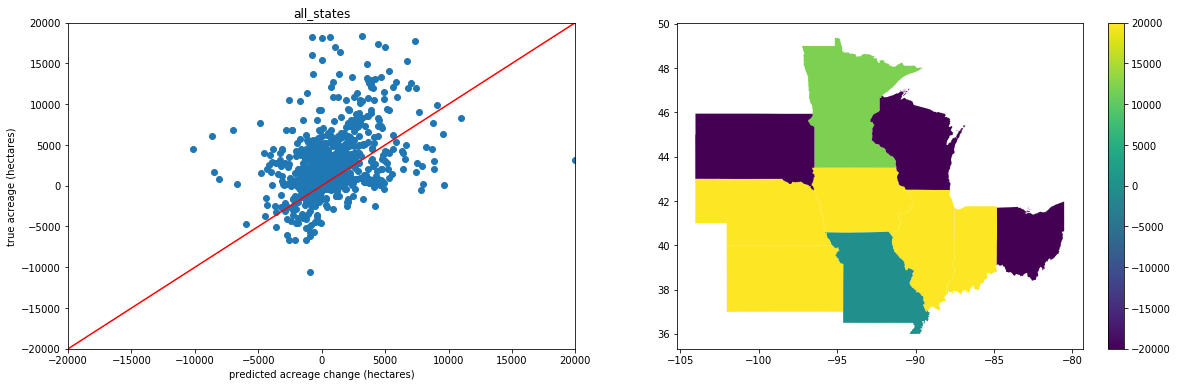

doing prediction for 1997 from 1996
our solution was 0.452102 as close as naive
RMSE: 163875.313953
Last Year's RMSE: 362473.994725


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  1997       corn  South Dakota        -45113   -83363        496077  38251             46           True
1  1997       corn          Iowa        127038  -202343        323749 329381            163          False
2  1997       corn        Kansas        -43076   101171        141640 144247            143          False
3  1997       corn     Minnesota         70766  -203428        323818 274195            135          False
4  1997       corn      Illinois        215262    80937        323749 134324            166           True
5  1997       corn      Nebraska         19776   161793        202302 142018             88           True
6  1997       corn      Missouri         73553    20427        403840  53126            260           True
7  1997       corn       Indiana        125252   121215         82044   4036              3           True
8  1997       corn          Ohio        180636   323789       -121365 143153             44           True
9  1997       corn     Wisconsin        -52086   -19483        100614  32603            167           True

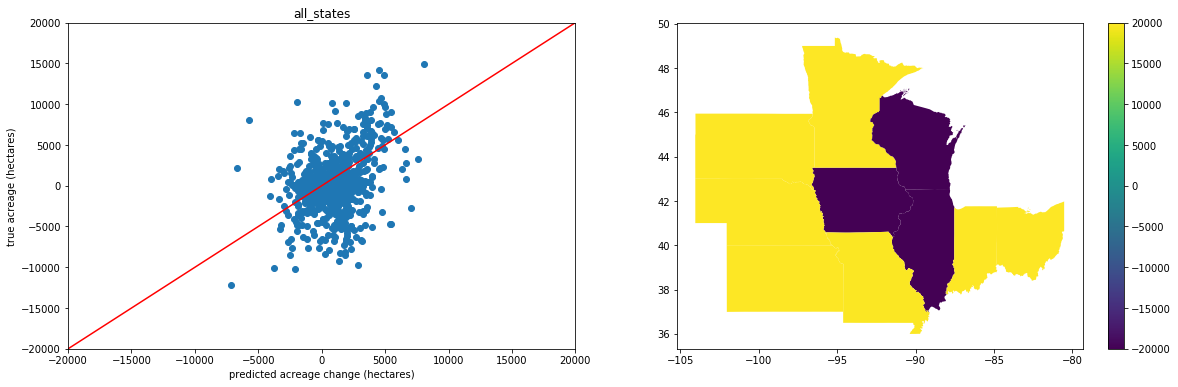

doing prediction for 1998 from 1997
our solution was 0.329400 as close as naive
RMSE: 79434.579129
Last Year's RMSE: 241148.975039


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  1998       corn  South Dakota        116257    40127        -83363  76130            190           True
1  1998       corn          Iowa        -65745   121406       -202343 187150            154          False
2  1998       corn        Kansas        138503   101171        101171  37331             37           True
3  1998       corn     Minnesota         39024   121725       -203428  82701             68           True
4  1998       corn      Illinois       -177040  -242811         80937  65771             27           True
5  1998       corn      Nebraska       -109256   -40469        161793  68788            170           True
6  1998       corn      Missouri         12610   -19693         20427  32303            164          False
7  1998       corn       Indiana        -96690   -40370        121215  56320            140           True
8  1998       corn          Ohio       -106023  -101171        323789   4851              5           True
9  1998       corn     Wisconsin        -33449   -60798        -19483  27349             45           True

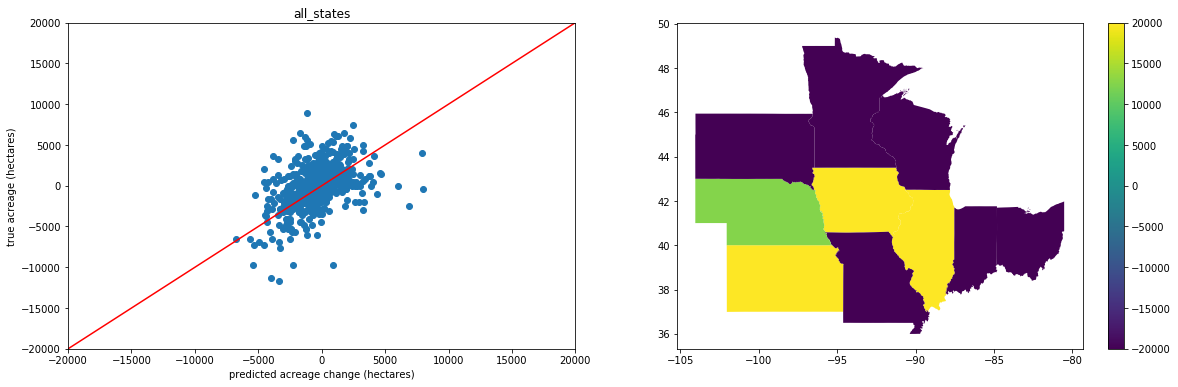

doing prediction for 1999 from 1998
our solution was 0.503559 as close as naive
RMSE: 81571.923063
Last Year's RMSE: 161990.642563


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  1999       corn  South Dakota         45777  -125038         40127 170815            137          False
1  1999       corn          Iowa       -132996  -161874        121406  28878             18           True
2  1999       corn        Kansas        106861    60703        101171  46159             76           True
3  1999       corn     Minnesota         18197   -79854        121725  98051            123          False
4  1999       corn      Illinois         77803    80937       -242811   3134              4           True
5  1999       corn      Nebraska        -17002   -80937        -40469  63935             79           True
6  1999       corn      Missouri         95353      375        -19693  94978          25297           True
7  1999       corn       Indiana         29437      283        -40370  29154          10291           True
8  1999       corn          Ohio         53210   -40388       -101171  93597            232          False
9  1999       corn     Wisconsin          4784   -40545        -60798  45330            112          False

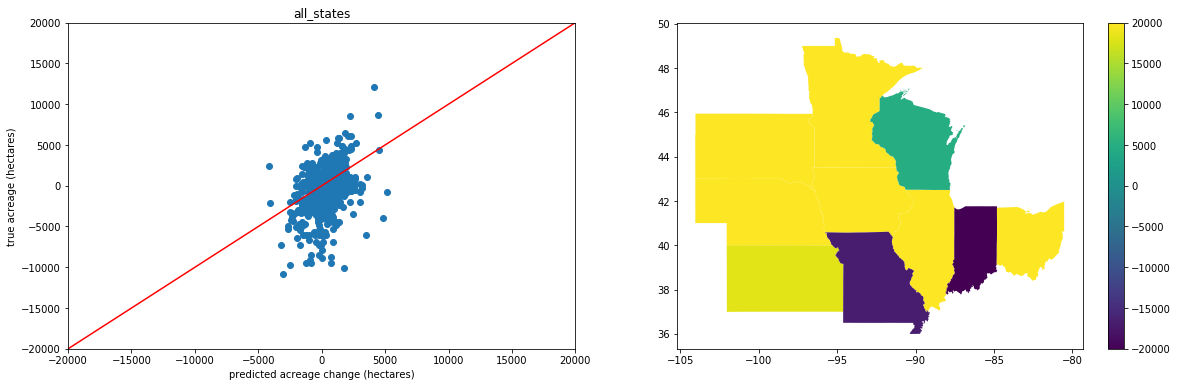

doing prediction for 2000 from 1999
our solution was 0.539832 as close as naive
RMSE: 88608.268312
Last Year's RMSE: 164140.425163


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2000       corn  South Dakota         76953   286776       -125038 209823             73           True
1  2000       corn          Iowa         93012    80937       -161874  12075             15           True
2  2000       corn        Kansas         42585   121406         60703  78821             65           True
3  2000       corn     Minnesota         97357    40155        -79854  57202            142           True
4  2000       corn      Illinois         27490   161874         80937 134385             83           True
5  2000       corn      Nebraska        -14604   -40469        -80937  25865             64           True
6  2000       corn      Missouri         79982    80544           375    562              1           True
7  2000       corn       Indiana         19025   -40201           283  59226            147          False
8  2000       corn          Ohio         19276    40428        -40388  21152             52           True
9  2000       corn     Wisconsin          5561   -41071        -40545  46632            114          False

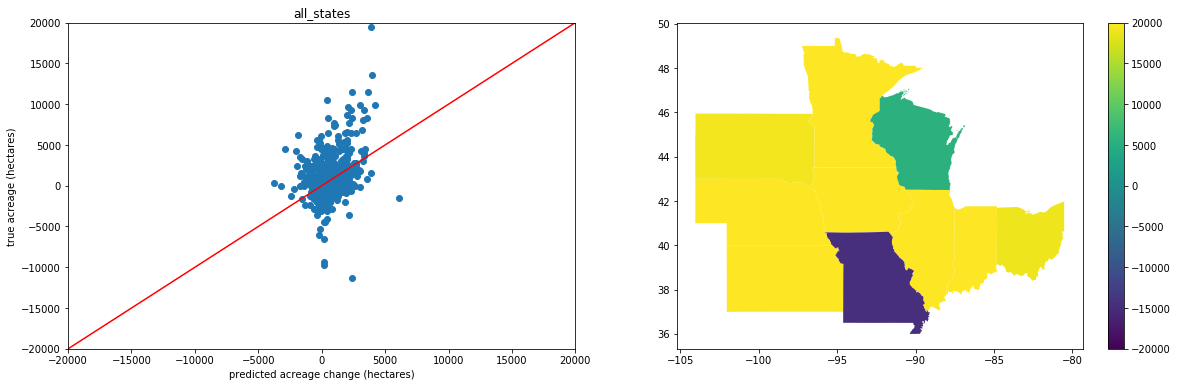

doing prediction for 2001 from 2000
our solution was 0.598438 as close as naive
RMSE: 135057.329420
Last Year's RMSE: 225682.982353


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2001       corn  South Dakota        -22017  -201938        286776 179921             89           True
1  2001       corn          Iowa           597  -242811         80937 243409            100          False
2  2001       corn        Kansas        -25130      -26        121406  25104          97091           True
3  2001       corn     Minnesota         39879  -161666         40155 201545            125          False
4  2001       corn      Illinois         18159   -80937        161874  99096            122          False
5  2001       corn      Nebraska        -51310  -161712        -40469 110401             68           True
6  2001       corn      Missouri         73603   -60317         80544 133920            222          False
7  2001       corn       Indiana         31800    40282        -40201   8482             21           True
8  2001       corn          Ohio         28924   -60662         40428  89587            148          False
9  2001       corn     Wisconsin         -1806   -40464        -41071  38658             96           True

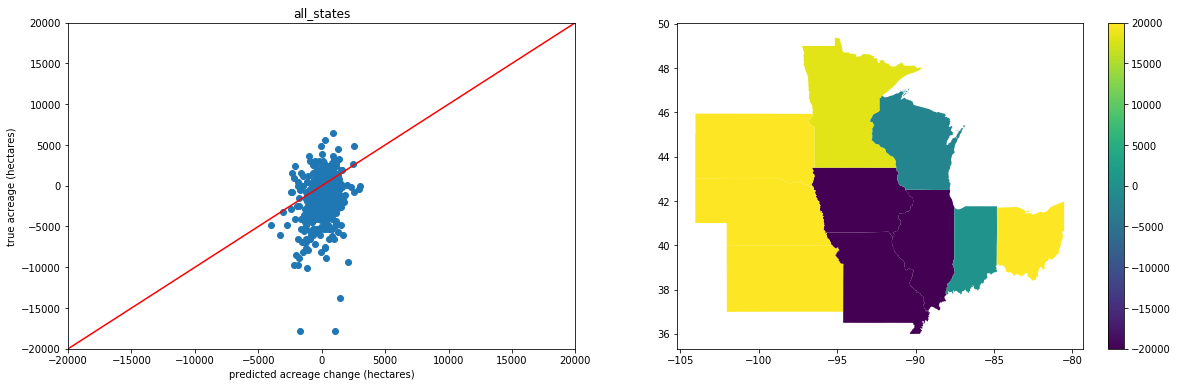

doing prediction for 2002 from 2001
our solution was 0.435619 as close as naive
RMSE: 114500.278141
Last Year's RMSE: 262844.712923


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2002       corn  South Dakota         68742   262641       -201938 193899             74           True
1  2002       corn          Iowa         58370   202343       -242811 143973             71           True
2  2002       corn        Kansas         18982   -80911           -26  99894            123          False
3  2002       corn     Minnesota         52171   161423       -161666 109253             68           True
4  2002       corn      Illinois         29262    40469        -80937  11207             28           True
5  2002       corn      Nebraska         58654   121420       -161712  62766             52           True
6  2002       corn      Missouri         26824    40625        -60317  13800             34           True
7  2002       corn       Indiana         -6255  -161775         40282 155520             96           True
8  2002       corn          Ohio         32627   -60456        -60662  93083            154          False
9  2002       corn     Wisconsin        -16230   101060        -40464 117290            116          False

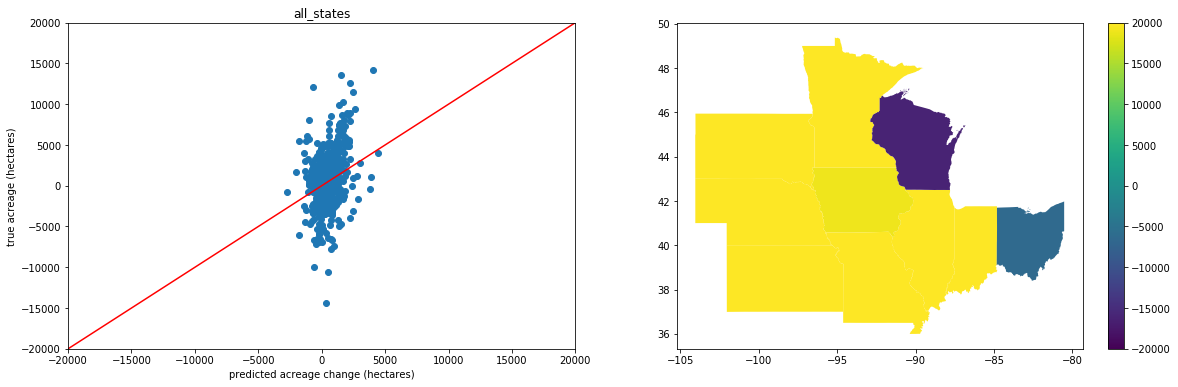

doing prediction for 2003 from 2002
our solution was 0.380198 as close as naive
RMSE: 61717.224379
Last Year's RMSE: 162329.162004


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2003       corn  South Dakota        -64425   -19830        262641  44596            225           True
1  2003       corn          Iowa         10855    40469        202343  29614             73           True
2  2003       corn        Kansas          1750  -140552        -80911 142301            101          False
3  2003       corn     Minnesota         60927      405        161423  60522          14955           True
4  2003       corn      Illinois          4067    40469         40469  36402             90           True
5  2003       corn      Nebraska        -58544  -121178        121420  62634             52           True
6  2003       corn      Missouri         18076    40754         40625  22678             56           True
7  2003       corn       Indiana         43719    81251       -161775  37532             46           True
8  2003       corn          Ohio        -13583    20028        -60456  33611            168          False
9  2003       corn     Wisconsin        -14126    40748        101060  54873            135          False

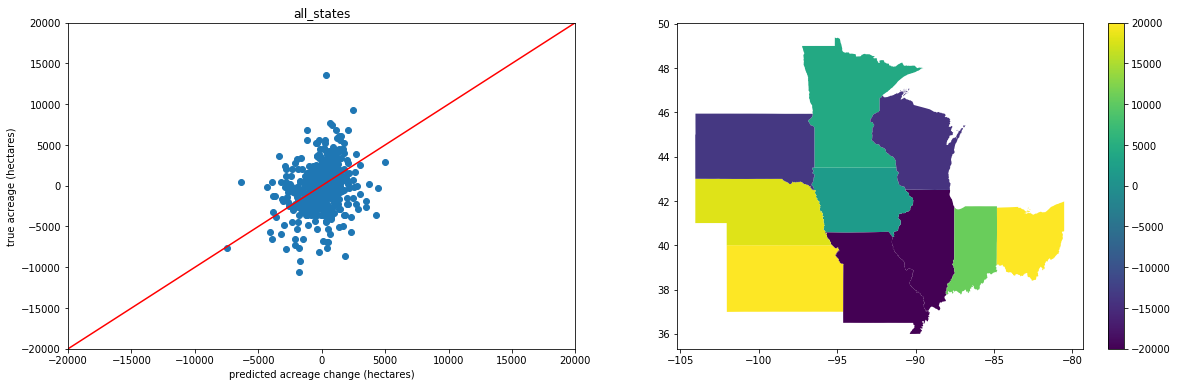

doing prediction for 2004 from 2003
our solution was 0.888709 as close as naive
RMSE: 116958.264636
Last Year's RMSE: 131604.661930


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2004       corn  South Dakota        -64280   101981        -19830 166261            163          False
1  2004       corn          Iowa         70388   161874         40469  91486             57           True
2  2004       corn        Kansas         53518    79849       -140552  26331             33           True
3  2004       corn     Minnesota         -5108   128470           405 133578            104          False
4  2004       corn      Illinois          8608   222577         40469 213969             96           True
5  2004       corn      Nebraska        -27325    60670       -121178  87995            145          False
6  2004       corn      Missouri        -54375    20337         40754  74712            367          False
7  2004       corn       Indiana        -91389    39351         81251 130740            332          False
8  2004       corn          Ohio        -55633    20991         20028  76623            365          False
9  2004       corn     Wisconsin        -47338   -60436         40748  13098             22           True

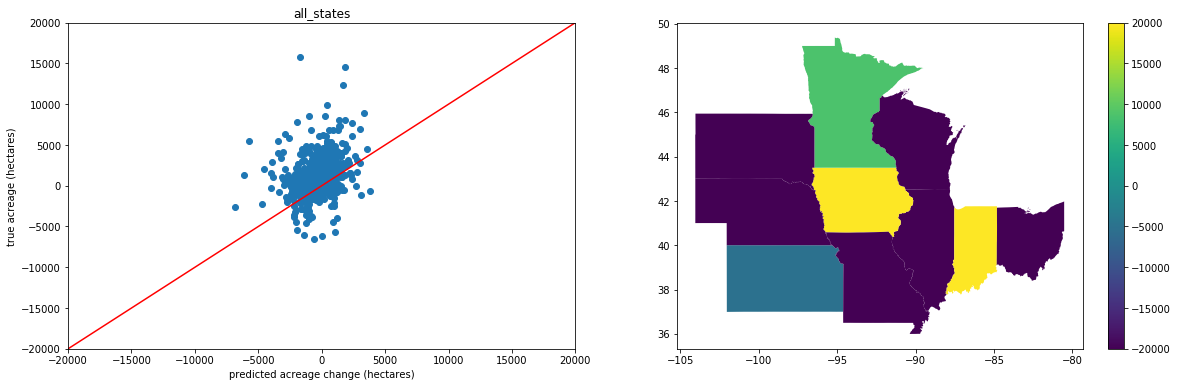

doing prediction for 2005 from 2004
our solution was 0.994973 as close as naive
RMSE: 120208.894232
Last Year's RMSE: 120816.286795


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2005       corn  South Dakota         52715   -80182        101981 132896            166          False
1  2005       corn          Iowa        102871    40469        161874  62402            154           True
2  2005       corn        Kansas        124389   222928         79849  98539             44           True
3  2005       corn     Minnesota        195473   -84921        128470 280395            330          False
4  2005       corn      Illinois         80735   141640        222577  60905             43           True
5  2005       corn      Nebraska         61613   101184         60670  39571             39           True
6  2005       corn      Missouri        184460    61918         20337 122542            198           True
7  2005       corn       Indiana         79238    81292         39351   2054              3           True
8  2005       corn          Ohio         94159    39631         20991  54527            138           True
9  2005       corn     Wisconsin        -25504    81012        -60436 106517            131          False

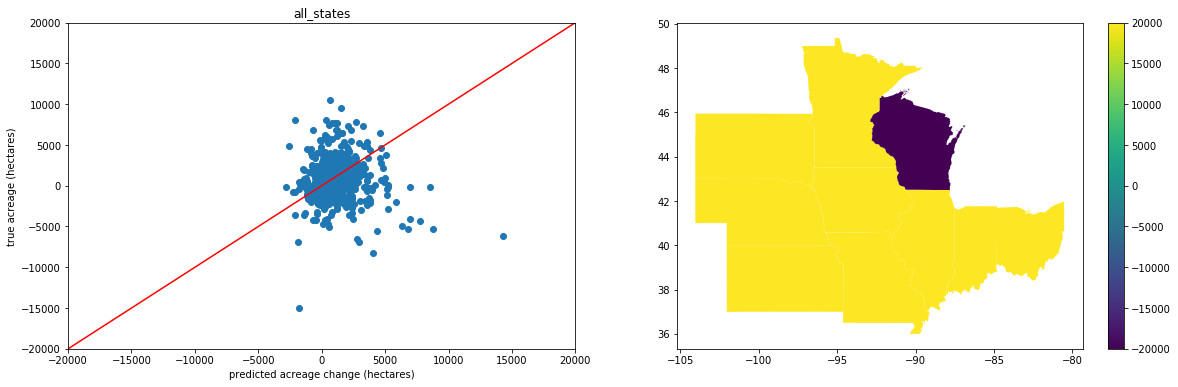

doing prediction for 2006 from 2005
our solution was 0.756427 as close as naive
RMSE: 183764.026630
Last Year's RMSE: 242936.834332


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2006       corn  South Dakota         91119    25819        -80182  65300            253           True
1  2006       corn          Iowa         80510   -80937         40469 161447            199          False
2  2006       corn        Kansas        117325  -119913        222928 237238            198          False
3  2006       corn     Minnesota        190134    -1624        -84921 191758          11808          False
4  2006       corn      Illinois        -58251  -323749        141640 265498             82           True
5  2006       corn      Nebraska         73298  -162016        101184 235314            145          False
6  2006       corn      Missouri         27665  -161456         61918 189120            117          False
7  2006       corn       Indiana         11175  -160853         81292 172028            107          False
8  2006       corn          Ohio         12739  -119382         39631 132121            111          False
9  2006       corn     Wisconsin         14451   -60595         81012  75046            124          False

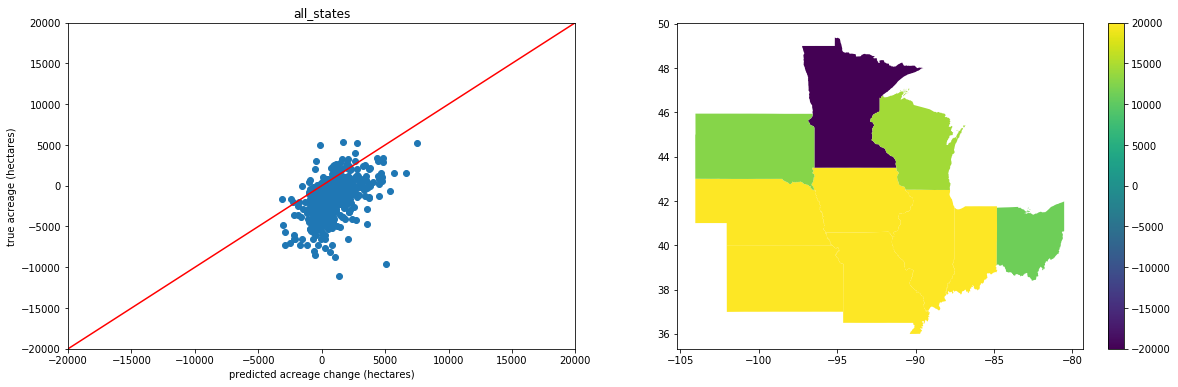

doing prediction for 2007 from 2006
our solution was 0.625992 as close as naive
RMSE: 358718.284217
Last Year's RMSE: 573039.610179


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2007       corn  South Dakota        -17504   178716         25819 196220            110          False
1  2007       corn          Iowa         79670   647497        -80937 567827             88           True
2  2007       corn        Kansas         -1864   222620       -119913 224484            101          False
3  2007       corn     Minnesota        111868   443975         -1624 332108             75           True
4  2007       corn      Illinois        153991   768903       -323749 614911             80           True
5  2007       corn      Nebraska         76059   526277       -162016 450218             86           True
6  2007       corn      Missouri        107830   304212       -161456 196382             65           True
7  2007       corn       Indiana        101597   403717       -160853 302120             75           True
8  2007       corn          Ohio        105399   282016       -119382 176617             63           True
9  2007       corn     Wisconsin          9228   161938        -60595 152710             94           True

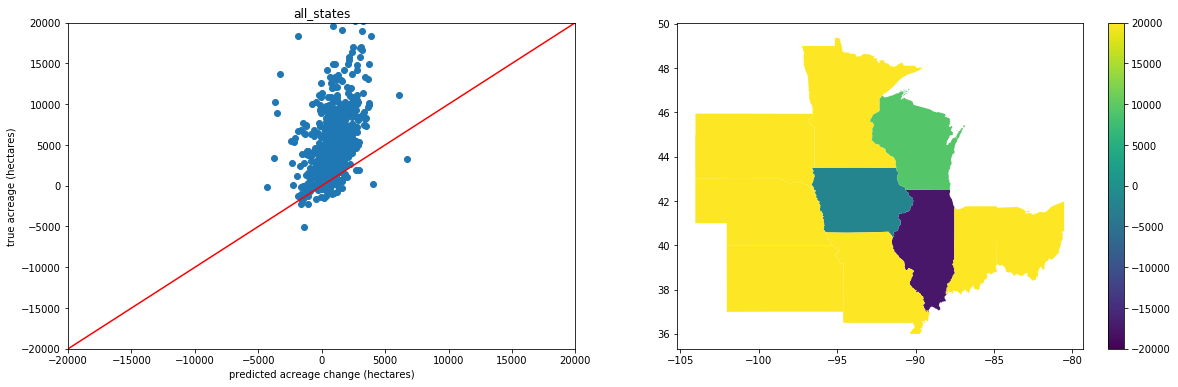

doing prediction for 2008 from 2007
our solution was 0.403449 as close as naive
RMSE: 283244.880744
Last Year's RMSE: 702059.077152


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2008       corn  South Dakota         28516   -78453        178716 106969            136          False
1  2008       corn          Iowa         23489  -364217        647497 387706            106          False
2  2008       corn        Kansas        124797   -35916        222620 160713            447          False
3  2008       corn     Minnesota         42328  -288246        443975 330574            115          False
4  2008       corn      Illinois          9162  -443181        768903 452343            102          False
5  2008       corn      Nebraska          4084  -242310        526277 246395            102          False
6  2008       corn      Missouri         32283  -265804        304212 298087            112          False
7  2008       corn       Indiana        -14265  -324071        403717 309806             96           True
8  2008       corn          Ohio         -8197  -220026        282016 211829             96           True
9  2008       corn     Wisconsin          -128  -102000        161938 101872            100           True

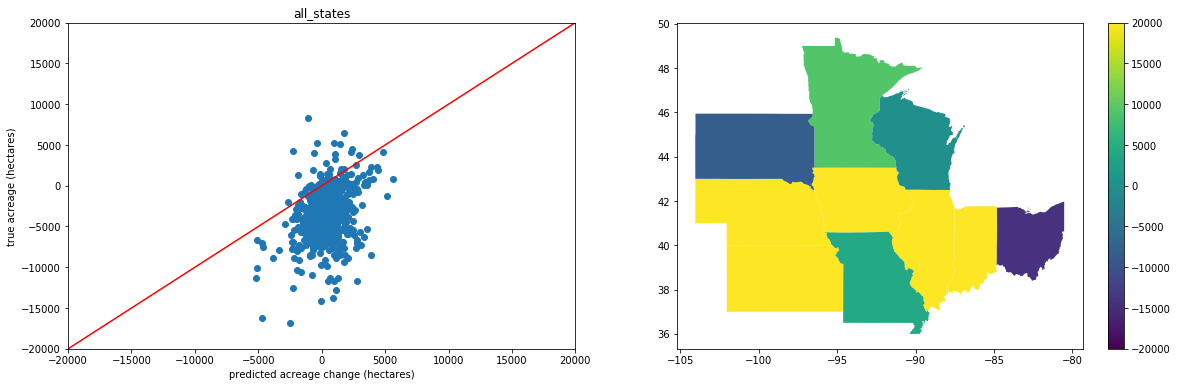

doing prediction for 2009 from 2008
our solution was 0.550730 as close as naive
RMSE: 169439.725635
Last Year's RMSE: 307663.975648


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2009       corn  South Dakota          2698   100569        -78453  97871             97           True
1  2009       corn          Iowa       -304094   121406       -364217 425500            350          False
2  2009       corn        Kansas        172300   123011        -35916  49289             40           True
3  2009       corn     Minnesota        -88701   -32135       -288246  56566            176           True
4  2009       corn      Illinois       -154468   -41051       -443181 113417            276           True
5  2009       corn      Nebraska        -84713   148028       -242310 232741            157          False
6  2009       corn      Missouri         42011    80694       -265804  38683             48           True
7  2009       corn       Indiana        -67407   -39878       -324071  27529             69           True
8  2009       corn          Ohio        -73112    20823       -220026  93934            451          False
9  2009       corn     Wisconsin        -92623    20207       -102000 112830            558          False

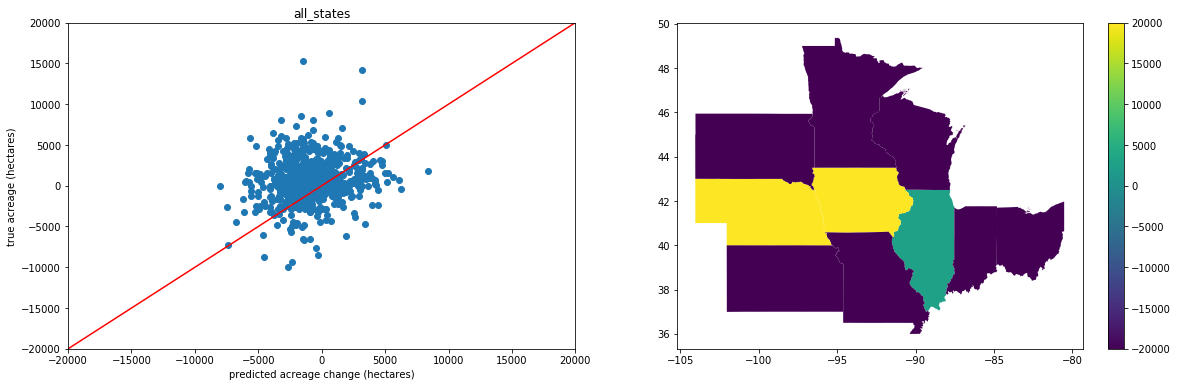

doing prediction for 2010 from 2009
our solution was 0.811526 as close as naive
RMSE: 136706.847629
Last Year's RMSE: 168456.600562


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2010       corn  South Dakota         17767  -189809        100569 207576            109          False
1  2010       corn          Iowa       -121426   -80937        121406  40489             50           True
2  2010       corn        Kansas         30740   276233        123011 245494             89           True
3  2010       corn     Minnesota         56414    39273        -32135  17141             44           True
4  2010       corn      Illinois         10422   240708        -41051 230285             96           True
5  2010       corn      Nebraska        -71699    -6589        148028  65109            988           True
6  2010       corn      Missouri         -9863    59091         80694  68953            117          False
7  2010       corn       Indiana         -1686   120970        -39878 122656            101          False
8  2010       corn          Ohio         -9000    38271         20823  47271            124          False
9  2010       corn     Wisconsin        -27597    20313         20207  47911            236          False

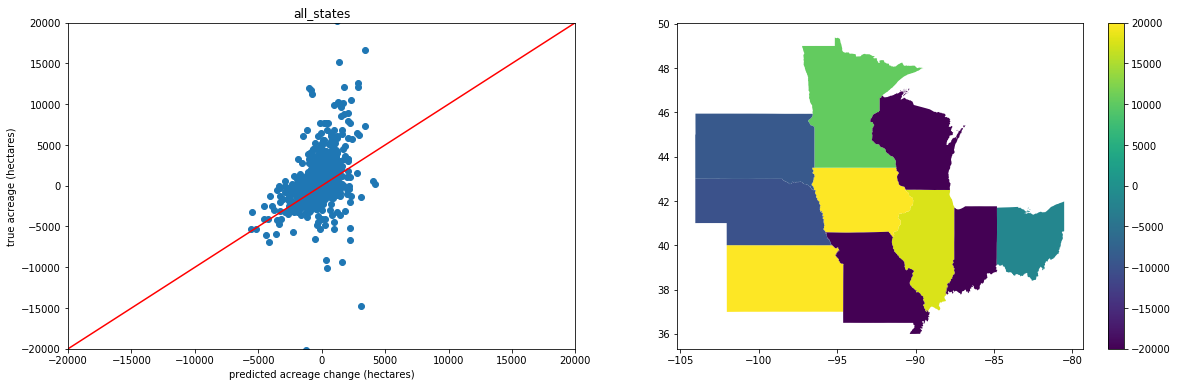

doing prediction for 2011 from 2010
our solution was 0.931133 as close as naive
RMSE: 222749.049913
Last Year's RMSE: 239223.636958


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2011       corn  South Dakota        309561   256496       -189809  53065             21           True
1  2011       corn          Iowa        681912   283280        -80937 398632            141           True
2  2011       corn        Kansas        127378    29169        276233  98209            337           True
3  2011       corn     Minnesota        511690   158984         39273 352706            222           True
4  2011       corn      Illinois        259253     -127        240708 259380         204319          False
5  2011       corn      Nebraska        478096   284126         -6589 193970             68           True
6  2011       corn      Missouri        181824    52392         59091 129433            247           True
7  2011       corn       Indiana        208258     6963        120970 201296           2891           True
8  2011       corn          Ohio        167680   -18150         38271 185830           1024          False
9  2011       corn     Wisconsin        160613    99832         20313  60781             61           True

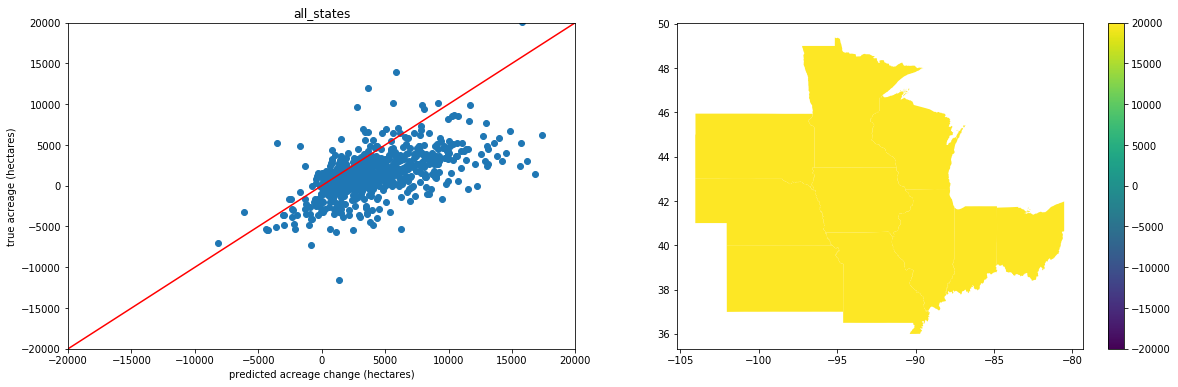

doing prediction for 2012 from 2011
our solution was 1.022301 as close as naive
RMSE: 151054.226337
Last Year's RMSE: 147759.096193


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2012       corn  South Dakota         -4567   379134        256496 383701            101          False
1  2012       corn          Iowa        -42251    40469        283280  82719            204          False
2  2012       corn        Kansas        -37062   -70240         29169  33178             47           True
3  2012       corn     Minnesota         79663   259814        158984 180151             69           True
4  2012       corn      Illinois         34212    69301          -127  35089             51           True
5  2012       corn      Nebraska        -73800    60672        284126 134472            222          False
6  2012       corn      Missouri         75947   128366         52392  52419             41           True
7  2012       corn       Indiana         65045   133308          6963  68263             51           True
8  2012       corn          Ohio        117420   199664        -18150  82244             41           True
9  2012       corn     Wisconsin         -2956    81092         99832  84047            104          False

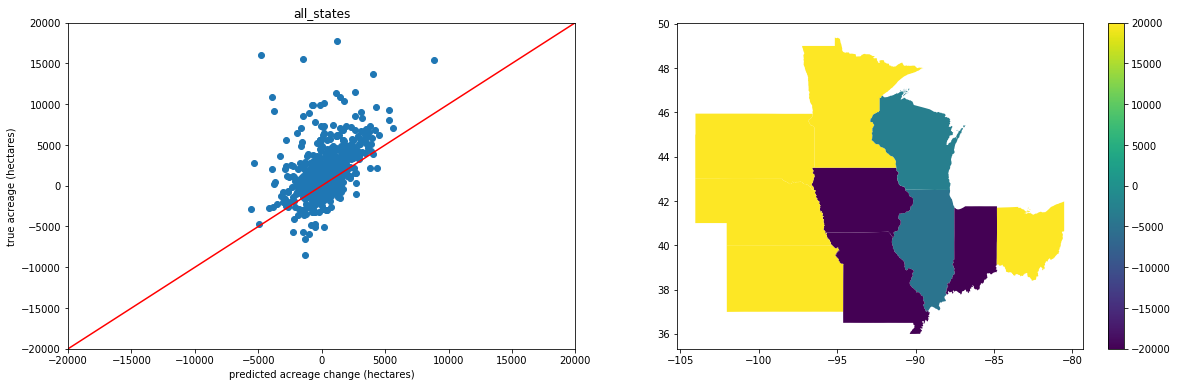

doing prediction for 2013 from 2012
our solution was 1.259977 as close as naive
RMSE: 317857.457655
Last Year's RMSE: 252272.474019


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2013       corn  South Dakota         24606    24665        379134     59              0           True
1  2013       corn          Iowa        389551  -242811         40469 632363            260          False
2  2013       corn        Kansas        208210  -157955        -70240 366164            232          False
3  2013       corn     Minnesota        209640   -66671        259814 276312            414          False
4  2013       corn      Illinois        129599  -300078         69301 429678            143          False
5  2013       corn      Nebraska        364829   -19133         60672 383962           2007          False
6  2013       corn      Missouri        -32723   -94519        128366  61797             65           True
7  2013       corn       Indiana         24455   -95861        133308 120316            126          False
8  2013       corn          Ohio        -50997     -499        199664  50498          10116           True
9  2013       corn     Wisconsin        121669   -95431         81092 217100            227          False

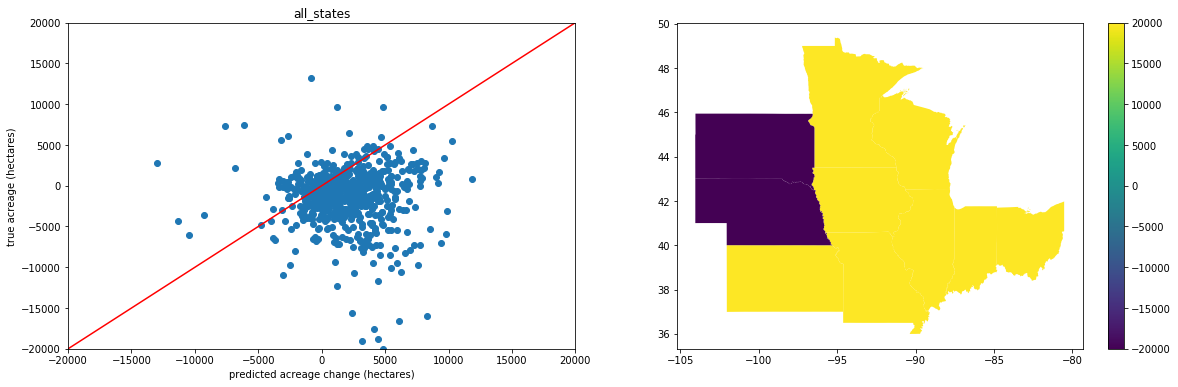

doing prediction for 2014 from 2013
our solution was 2.631475 as close as naive
RMSE: 444493.088028
Last Year's RMSE: 168914.016193


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2014       corn  South Dakota       -436112  -167606         24665 268506            160           True
1  2014       corn          Iowa       -889103    40469       -242811 929571           2297          False
2  2014       corn        Kansas       -347749   -70920       -157955 276830            390           True
3  2014       corn     Minnesota       -564092  -148941        -66671 415150            279           True
4  2014       corn      Illinois       -687113   -53272       -300078 633841           1190           True
5  2014       corn      Nebraska       -695551  -267415        -19133 428136            160           True
6  2014       corn      Missouri       -141855    46126        -94519 187981            408          False
7  2014       corn       Indiana       -341735   -43855        -95861 297880            679           True
8  2014       corn          Ohio       -240169   -80272          -499 159897            199           True
9  2014       corn     Wisconsin       -283279   -46916        -95431 236363            504           True

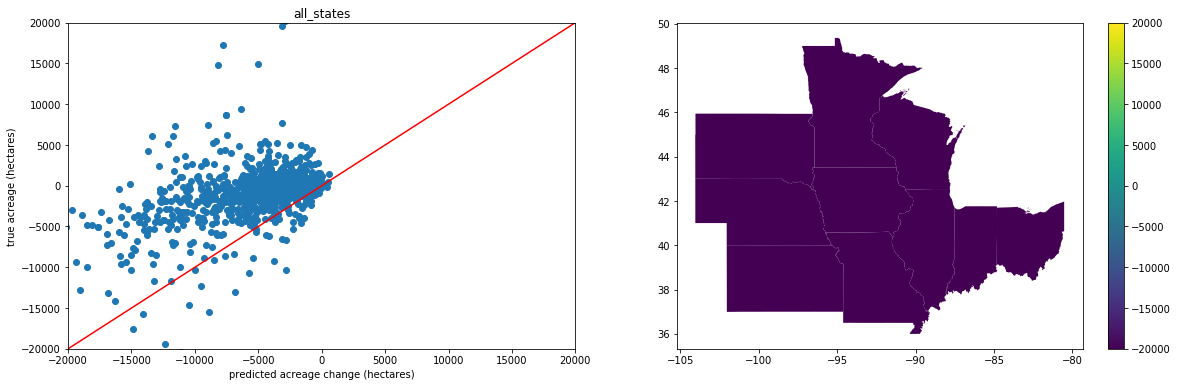

doing prediction for 2015 from 2014
our solution was 0.988268 as close as naive
RMSE: 127052.411307
Last Year's RMSE: 128560.726914


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2015       corn  South Dakota         88150  -154827       -167606 242977            157          False
1  2015       corn          Iowa       -146615   -80145         40469  66470             83           True
2  2015       corn        Kansas        249471    33132        -70920 216339            653           True
3  2015       corn     Minnesota         49478   -48399       -148941  97877            202          False
4  2015       corn      Illinois        -31429   -88432        -53272  57003             64           True
5  2015       corn      Nebraska         79683    56690       -267415  22994             41           True
6  2015       corn      Missouri         41069   -84854         46126 125923            148          False
7  2015       corn       Indiana          9233  -103472        -43855 112705            109          False
8  2015       corn          Ohio         32989   -59593        -80272  92582            155          False
9  2015       corn     Wisconsin        -25862      144        -46916  26005          18091          False

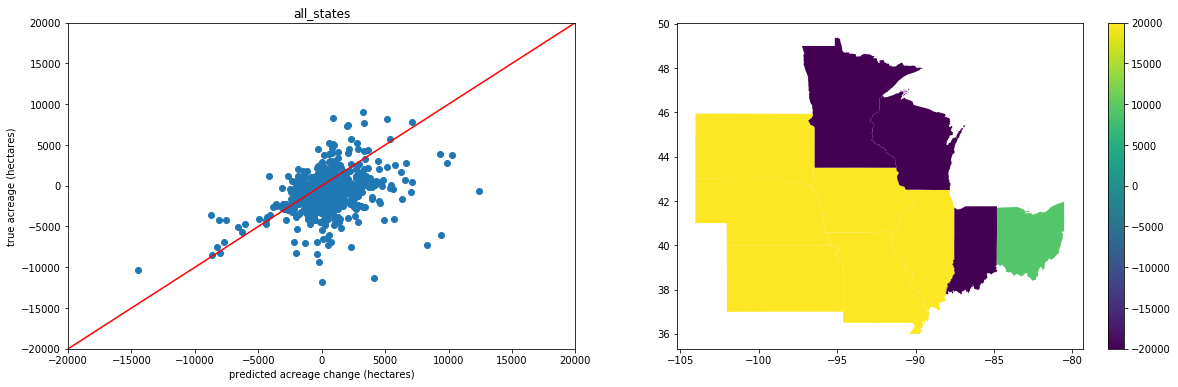

doing prediction for 2016 from 2015
our solution was 0.670198 as close as naive
RMSE: 121491.007944
Last Year's RMSE: 181276.188379


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2016       corn  South Dakota        116135    61288       -154827  54848             89           True
1  2016       corn          Iowa         82545   161082        -80145  78537             49           True
2  2016       corn        Kansas         38141   354375         33132 316234             89           True
3  2016       corn     Minnesota        164838   144134        -48399  20704             14           True
4  2016       corn      Illinois        -42128   -20539        -88432  21589            105           True
5  2016       corn      Nebraska         32333   173141         56690 140808             81           True
6  2016       corn      Missouri         23040   149167        -84854 126127             85           True
7  2016       corn       Indiana         15186   -21766       -103472  36953            170          False
8  2016       corn          Ohio         18784    -1755        -59593  20539           1170          False
9  2016       corn     Wisconsin         24238    22314           144   1924              9           True

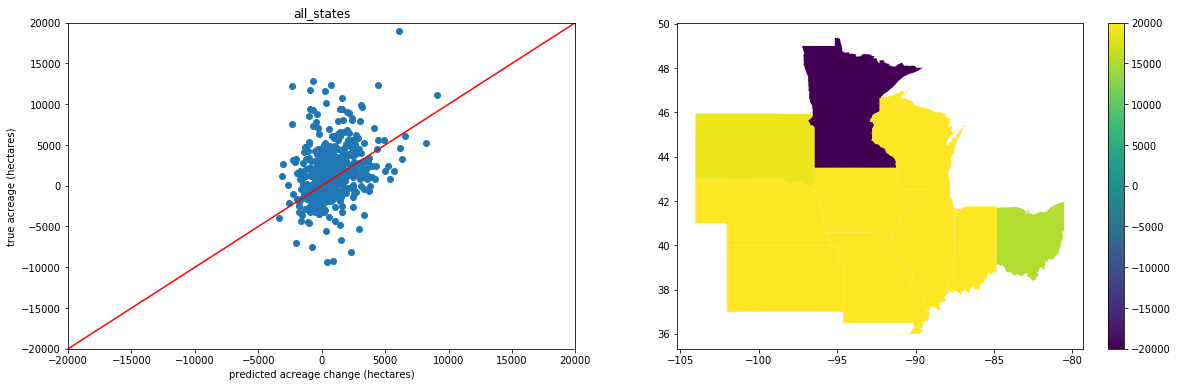

doing prediction for 2017 from 2016
our solution was 0.335870 as close as naive
RMSE: 77881.443193
Last Year's RMSE: 231879.659193


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2017       corn  South Dakota        -65527    27761         61288  93288            336          False
1  2017       corn          Iowa       -183646  -247539        161082  63893             26           True
2  2017       corn        Kansas        -64569   116632        354375 181201            155          False
3  2017       corn     Minnesota       -104923  -177829        144134  72907             41           True
4  2017       corn      Illinois       -118796  -169493        -20539  50696             30           True
5  2017       corn      Nebraska       -153141  -151270        173141   1872              1           True
6  2017       corn      Missouri        -52161  -107356        149167  55195             51           True
7  2017       corn       Indiana        -72291   -96248        -21766  23957             25           True
8  2017       corn          Ohio        -74736   -57620         -1755  17116             30           True
9  2017       corn     Wisconsin         -7431   -64301         22314  56870             88           True

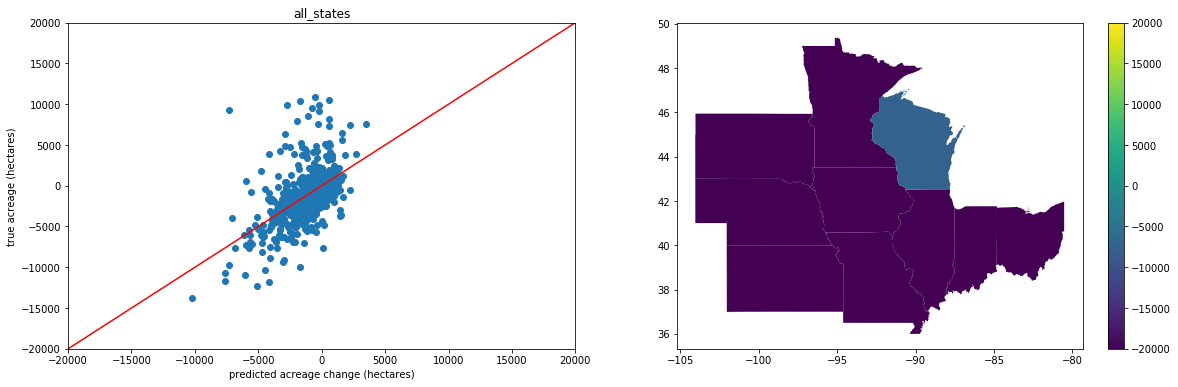

doing prediction for 2018 from 2017
our solution was 3.042653 as close as naive
RMSE: 433642.124712
Last Year's RMSE: 142521.080624


year state_name          crop  predicted_dy  true_dy  last_year_dy  error  percent_error  sign_accurate
0  2018       corn  South Dakota        269446  -152936         27761 422382            276          False
1  2018       corn          Iowa        687426   -39050       -247539 726476           1860          False
2  2018       corn        Kansas        269725   -45068        116632 314793            698          False
3  2018       corn     Minnesota        521936   -76649       -177829 598585            781          False
4  2018       corn      Illinois        535188   -73903       -169493 609091            824          False
5  2018       corn      Nebraska        418509    27867       -151270 390643           1402           True
6  2018       corn      Missouri        270106    51502       -107356 218604            424           True
7  2018       corn       Indiana        295206     7507        -96248 287700           3832           True
8  2018       corn          Ohio        216381    38602        -57620 177779            461           True
9  2018       corn     Wisconsin        176404      -17        -64301 176421        1022319          False

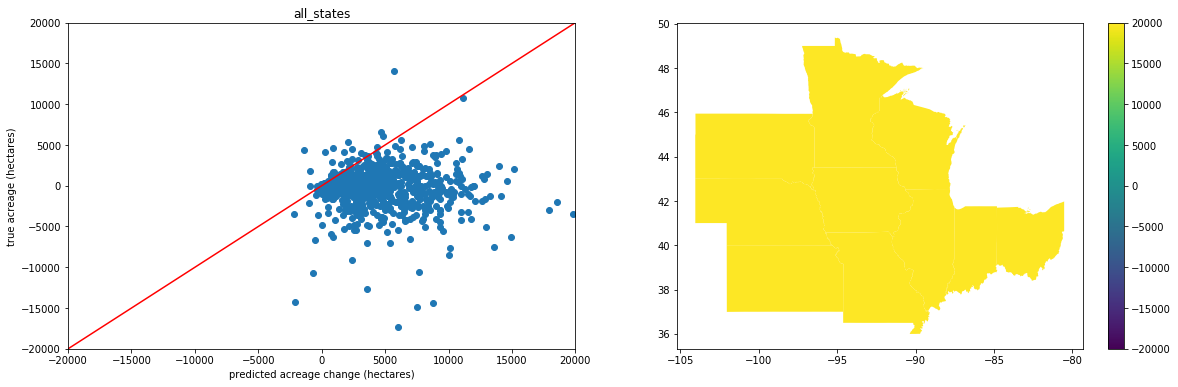

doing prediction for 2019 from 2018
our solution was 5.102764 as close as naive
RMSE: 938463.049436
Last Year's RMSE: 183912.675254


year state_name          crop  predicted_dy  true_dy  last_year_dy   error  percent_error  sign_accurate
0  2019       corn  South Dakota       -579774   299409       -152936  879184            294          False
1  2019       corn          Iowa      -1226443   164807        -39050 1391249            844          False
2  2019       corn        Kansas      -1032611   149747        -45068 1182358            790          False
3  2019       corn     Minnesota       -881629    70583        -76649  952212           1349          False
4  2019       corn      Illinois      -1256769    71876        -73903 1328645           1849          False
5  2019       corn      Nebraska       -860484    56273         27867  916757           1629          False
6  2019       corn      Missouri       -490677     -807         51502  489870          60713           True
7  2019       corn       Indiana       -661511    52686          7507  714197           1356          False
8  2019       corn          Ohio       -545868     -694         38602  545174          78507           True
9  2019       corn     Wisconsin       -311718    63661           -17  375379            590          False

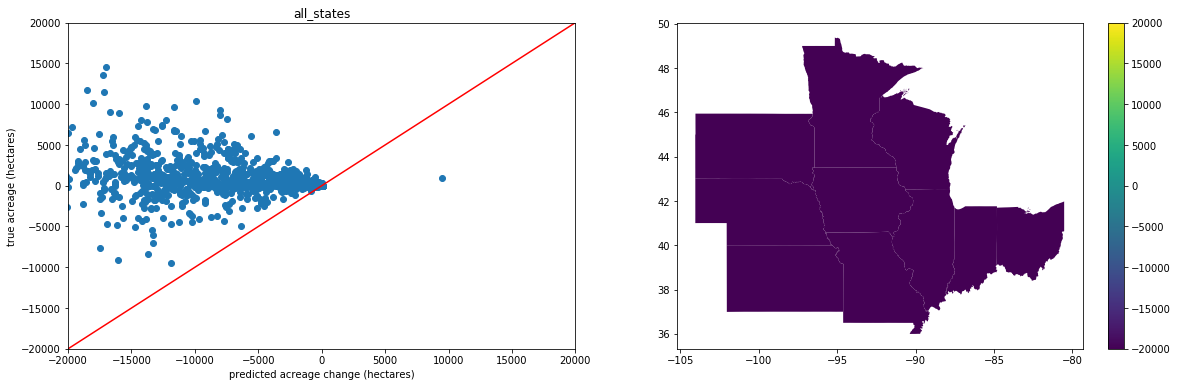

In [83]:
from sklearn import linear_model
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from sklearn.model_selection import KFold
from IPython.display import display
import plotly.plotly as py
import plotly.graph_objs as go
import geopandas

#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 2000)

kf = KFold(n_splits=num_samples-1)
df = geopandas.read_file("N_America_L1_OD_Gro.shp")
df = df.loc[df["NAME_1"].isin(state_ids.keys())]
        
for train_idxs, test_idxs in kf.split([0]*(num_samples-1)): #[(list(range(0,22)), [22])]: 

    predictions_over_all_states = np.array((0))
    true_over_all_states = np.array((0))
    print("doing prediction for %i from %i" % ((test_idxs[0] + 1 + 1995), (test_idxs[0] + 1995)))

    #print("Crop under analysis: " + crop)
    X_flat = X[:, train_idxs, :].reshape(-1, X.shape[-1])
    
    for crop in ["corn"]: #non_fsa_crops:
        
        total_error = 0.0
        total_error_naive = 0.0
        state_results = []
        
        y_flat = y[crop][:, train_idxs].reshape(-1)

        #feature_names = np.array(feature_names)
        reg = linear_model.Lasso(alpha=1.0).fit(X_flat, y_flat)

        for name, state_id in state_ids.items():

            s1, s2 = state_index_map[state_id]
            state_X = X[s1:s2, test_idxs, :].reshape((-1,X.shape[-1]))
            state_y = y[crop][s1:s2, :]

            county_predictions = reg.predict(state_X)
            predicted_sum = np.sum(county_predictions)
            
            predictions_over_all_states = np.append(predictions_over_all_states, county_predictions)
            true_over_all_states = np.append(true_over_all_states, state_y[:, test_idxs[0]])
            
            # no weighting
            true_state_sum = np.sum(state_y[:, test_idxs[0]])
            naive_sum = np.sum(state_y[:, test_idxs[0]-1])
            total_error += np.abs((predicted_sum - true_state_sum)**2)
            total_error_naive += np.abs((naive_sum - true_state_sum)**2)
            error = np.abs(true_state_sum - predicted_sum)
            perc_error = error/np.abs(true_state_sum)*100
            sign_accurate = ((np.sign(predicted_sum) * np.sign(true_state_sum)) > 0)
            state_results.append([(test_idxs[0] + 1 + 1995), 
                                  crop, name, predicted_sum, true_state_sum, naive_sum, error, perc_error, sign_accurate])

#             abs_coefs = np.abs(reg.coef_)
#             sorted_coefs_idxs = np.argsort(abs_coefs)
#             sorted_coefs_with_vals = zip(np.array(feature_names)[sorted_coefs_idxs], 
# reg.coef_[sorted_coefs_idxs])
#             print("feat. largest coef", feature_names[np.argmax(abs_coefs)])
#             #print("sorted coefficients with vals", sorted_coefs_with_vals[-10:])
#             #print(np.sum(training_data[:, :, np.argmax(reg.coef_)], axis=1))
#             print("feat. smallest coef", feature_names[np.argmin(abs_coefs)])
#             print(np.sum(training_data[:, :, np.argmin(abs_coefs)], axis=1))
        
#                     print(reg.coef_)
#                         plt.hist(reg.coef_)
#                         plt.show()


        finalcoef = (np.sqrt(total_error/len(state_ids)) / np.sqrt(total_error_naive/len(state_ids)))
        print("our solution was %f as close as naive" % finalcoef)
        print("RMSE: %f" % np.sqrt(total_error/len(state_ids)))
        print("Last Year's RMSE: %f" % np.sqrt(total_error_naive/len(state_ids)))

        state_results_dataframe = pd.DataFrame(state_results, 
                                               columns=["year", 
                                                        "state_name", 
                                                        "crop", 
                                                        "predicted_dy", 
                                                        "true_dy", 
                                                        "last_year_dy", 
                                                        "error", 
                                                        "percent_error", 
                                                        "sign_accurate"])
        pd.options.display.float_format = '{:.0f}'.format
        display(state_results_dataframe)

    fig, (ax_scatter, ax_chloro) = plt.subplots(1, 2, figsize=(20,6))
    x_0 = y_0 = np.min([np.min(predictions_over_all_states), np.min(true_over_all_states)])
    x_1 = y_1 = np.max([np.max(predictions_over_all_states), np.max(true_over_all_states)])

    xlim = ylim = 20000
    
    ax_scatter.plot([-xlim, xlim], [-ylim, ylim], c='r')
    ax_scatter.scatter(predictions_over_all_states, true_over_all_states)

    ax_scatter.set_xlabel("predicted acreage change (hectares)")
    ax_scatter.set_ylabel("true acreage (hectares)")
    ax_scatter.set_title("all_states")
    ax_scatter.set_xlim(-xlim, xlim)
    ax_scatter.set_ylim(-ylim, ylim)
    
    df["delta_area"] = state_results_dataframe["predicted_dy"].tolist()
    df.plot("delta_area", cmap='viridis', legend=True, ax=ax_chloro, vmin=-ylim, vmax=ylim)
    
    plt.show()
    
#def print_statistics(y_state, y_state_pred):

    # TODO: Chloropleth deviation
    
    # TODO: Chloropleth average acreage
    
    # TODO: Add yiqings plots here to make analysis complete. 

# see country statistics..
# do leave one out over all years..
# make a line chart with prediction vs year. one line for prediciton and one for true
# chloropleth map of average deviation (true - predicted) over space. 
# share notebook with 
